# 1. Introduction and Background
Describe what your notebook discusses and give some background information.
Be sure to include an "Eye Catching" graphic in the beginning of the notebook.

# 2. Examples
Teach the content you mentioned in your introduction. Use interactive widgets and animations to help "teach by example". Where applicable also use Python/R examples.

# 3. Include questions 
throughout/in its own section in order to engage the student/make it easier for a teacher to use your notebook.

# 4. Conclusion

# 5. Reiterate important learning objectives 
that you covered and explain where this knowledge is helpful

# Genetic Algorithms

In [34]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def print_pop(population):
    for i in population:
        print(i)

In [36]:

def initialize_map(p_zero, N):
    # first thing is to create the map that you're trying to navigate.  I will do this randomly.
    # This will be of the form of a adjacency matrix...
    # In other words, an NxN matrix where each row and column correspond to an intersection on a map
    # X_ij, then is equal to the amount of time that it takes to get from position i to position j
    # could also be considered a distance measure... but whatever is easier to think about.
    # practically, then we need a matrix that has numeric values in it... 
    # there should be some paths that don't exist.  I will assign these a 0.  
    # For instance, if you can't get directly from i to j, then X_ij = 0
    
    # The initialization needs some tuning parameters.  One is the proportion of 0's in the final result
    
    the_map = np.zeros((N,N))
    
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
                
    return the_map

In [37]:
# Let's make a more complicated map that has at least 10 stops that have to be made and see what happens.

def initialize_complex_map(p_zero, N, groups):

    the_map = np.zeros((N,N))
    
    for i in range(0, N):
        for j in range(0, i):
            group_i = int(i/(N/groups))
            group_j = int(j/(N/groups))
            
            if random.random() > p_zero and abs(group_i - group_j) <= 1:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
          
        
    ax = sns.heatmap(the_map)

    plt.show()
        
    return the_map

In [38]:
def create_starting_population(size, the_map):
    
    #this just creates a population of different routes of a fixed size.  Pretty straightforward.
    
    population = []
    
    for i in range(0,size):
        population.append(create_new_member(the_map))
        
    return population

In [39]:
def fitness(route, the_map):
    
    score = 0
    
    for i in range(1, len(route)):
        if (the_map[route[i-1]][route[i]] == 0) and i != len(the_map)-1:
            print("WARNING: INVALID ROUTE")
            print(route)
            print(the_map)
        score = score + the_map[route[i-1]][route[i]]

    return score

In [40]:
def crossover(a, b):
        
    # I initially made an error here by allowing routes to crossover at any point, which obviously won't work
    # you have to insure that when the two routes cross over that the resulting routes produce a valid route
    # which means that crossover points have to be at the same position value on the map
    
    common_elements = set(a) & set(b)
    
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a)) 
        value = random.sample(common_elements, 1)        
    
    cut_a = np.random.choice(np.where(np.isin(a, value))[0])
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:])
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
       
    return (new_a, new_b)

In [41]:

def mutate(route, probability, the_map):
    
    new_route = copy.deepcopy(route)
    
    for i in range(1, len(new_route)):
        if random.random() < probability:
            
            go = True

            while go:

                possible_values = np.nonzero(the_map[new_route[i-1]])
                proposed_value = random.randint(0,len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])

                if new_route[i] == len(the_map)-1:
                    go = False
                else:
                    i += 1
    
    return new_route

In [42]:

def create_new_member(the_map):
    # here we are going to create a new route
    # the new route can have any number of steps, so we'll select that randomly
    # the structure of the route will be a vector of integers where each value is the next step in the route
    # Everyone starts at 0, so the first value in the vector will indicate where to attempt to go next.
    # That is, if v_i = 4, then that would correspond to X_0,4 in the map that was created at initialization
    
    # N is the size of the map, so we need to make sure that 
    # we don't generate any values that exceed the size of the map

    N = len(the_map)
    
    route = np.zeros(1, dtype=int)

    go = True
    
    i = 1
    
    while go:
        
        possible_values = np.nonzero(the_map[route[i-1]])
        proposed_value = random.randint(0,len(possible_values[0])-1)
        route = np.append(route, possible_values[0][proposed_value])
                
        if route[i] == N-1:
            go = False
        else:
            i += 1
    
    return route

In [43]:
def score_population(population, the_map):
    
    scores = []
    
    for i in range(0, len(population)):
        scores += [fitness(population[i], the_map)]
        
    return scores

In [44]:

def pick_mate(scores):

    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))

    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    
    rand = random.random()
    
    for i in range(0, len(probs)):
        if rand < probs[i]:
            
            return i

In [45]:
def main():
    
    # parameters
    sparseness_of_map = 0.95
    size_of_map = 1000
    population_size = 30
    number_of_iterations = 1000
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    number_of_groups = 1
    
    # initialize the map and save it
    the_map = initialize_complex_map(sparseness_of_map, size_of_map, number_of_groups)

    # create the starting population
    population = create_starting_population(population_size, the_map)

    last_distance = 1000000000
    # for a large number of iterations do:
        
    for i in range(0,number_of_iterations):
        new_population = []
        
        # evaluate the fitness of the current population
        scores = score_population(population, the_map)

        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = fitness(best, the_map)
        if distance != last_distance:
            print('Iteration %i: Best so far is %i steps for a distance of %f' % (i, number_of_moves, distance))
            plot_best(the_map, best, i)

        
        # allow members of the population to breed based on their relative score; 
            # i.e., if their score is higher they're more likely to breed
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)])
            new_population = new_population + [new_1, new_2]
  
        # mutate
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        # keep members of previous generation
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
        # add new random members
        while len(new_population) < population_size:
            new_population += [create_new_member(the_map)]
            
        #replace the old population with a real copy
        population = copy.deepcopy(new_population)
                
        last_distance = distance
        
    # plot the results
        

In [46]:

def plot_best(the_map, route, iteration_number):
    ax = sns.heatmap(the_map)

    x=[0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(the_map) - 0.5]
    y=[0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(the_map) - 0.5]
    
    plt.plot(x, y, marker = 'o', linewidth=4, markersize=12, linestyle = "-", color='white')
    plt.savefig('C:/Users/ltang/Desktop/Intranet/new1000plot_%i.png' %(iteration_number), dpi=300)
    plt.show()

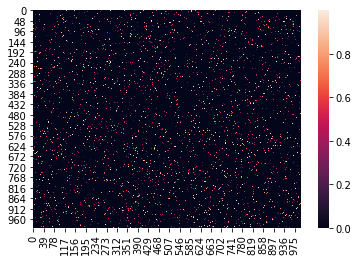

Iteration 0: Best so far is 81 steps for a distance of 32.617598


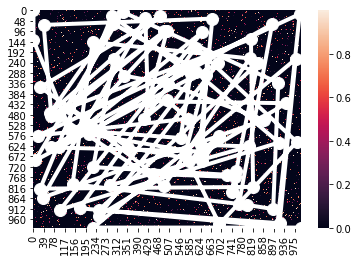

Iteration 1: Best so far is 26 steps for a distance of 11.735047


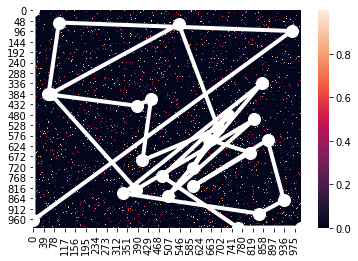

Iteration 3: Best so far is 6 steps for a distance of 1.870445


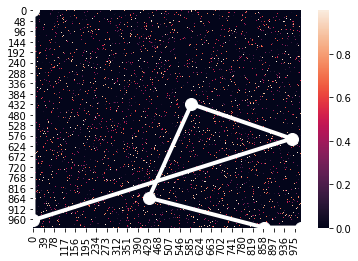

Iteration 14: Best so far is 5 steps for a distance of 1.001402


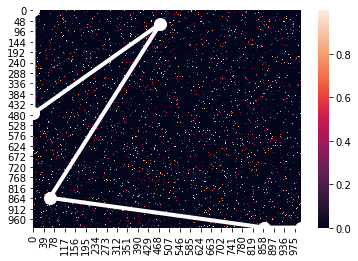

Iteration 297: Best so far is 3 steps for a distance of 0.613486


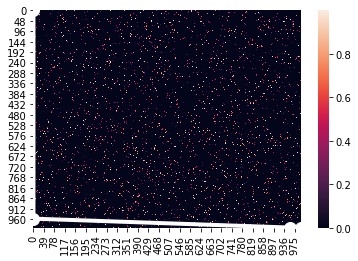

Iteration 632: Best so far is 5 steps for a distance of 0.359189


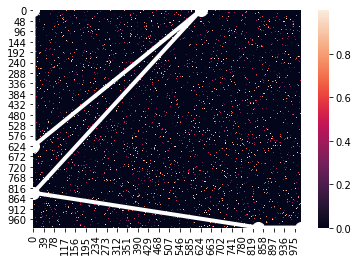

Iteration 671: Best so far is 3 steps for a distance of 0.248892


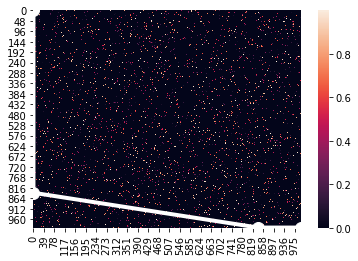

In [ ]:
main()

In [23]:
from ipywidgets import interact

In [24]:
def f(x):
    return x

In [3]:
interact(f,x=(0,10));  # a slider with integer outputs

interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

In [4]:
6

6

In [5]:
interact(f,x=(0.0,10.0)); # a slider with floating point outputs

interactive(children=(FloatSlider(value=5.0, description='x', max=10.0), Output()), _dom_classes=('widget-inte…

In [6]:
interact(f,x=True); # a check box with True/False output

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

In [7]:
interact(f,x='Hello World'); # an editable text box

interactive(children=(Text(value='Hello World', description='x'), Output()), _dom_classes=('widget-interact',)…

In [8]:
interact(f, x={'One': 1, 'Two': 2, 'Three': 3, 'Forty four': 44}); # a drop-down list

interactive(children=(Dropdown(description='x', options={'One': 1, 'Two': 2, 'Three': 3, 'Forty four': 44}, va…

In [9]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

In [10]:
x=linspace(0,1)

def update(k=0):
    plot(x,x**k)
    show()

In [11]:
interact(update,k=(1,10));

interactive(children=(IntSlider(value=1, description='k', max=10, min=1), Output()), _dom_classes=('widget-int…

In [12]:
t = linspace(0,1,1000)

def plot_sine(A=4,f=2,phi=0):
    plot(t,A*sin(2*pi*f*t + phi))
    axis([0,1,-6,6])
    show()

In [13]:
interact(plot_sine,A=(0,10), f=(1,10), phi=(0,2*pi));

interactive(children=(IntSlider(value=4, description='A', max=10), IntSlider(value=2, description='f', max=10,…

In [14]:
import networkx as nx

In [15]:
# wrap a few graph generation functions so they have the same signature

def random_lobster(n, m, k, p):
    return nx.random_lobster(n, p, p / m)

def powerlaw_cluster(n, m, k, p):
    return nx.powerlaw_cluster_graph(n, m, p)

def erdos_renyi(n, m, k, p):
    return nx.erdos_renyi_graph(n, p)

def newman_watts_strogatz(n, m, k, p):
    return nx.newman_watts_strogatz_graph(n, k, p)

def plot_random_graph(n, m, k, p, generator):
    g = generator(n, m, k, p)
    nx.draw(g)
    show()

In [16]:
interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
         generator={
             'lobster': random_lobster,
             'power law': powerlaw_cluster,
             'Newman-Watts-Strogatz': newman_watts_strogatz,
             u'Erdős-Rényi': erdos_renyi,
         });

interactive(children=(IntSlider(value=16, description='n', max=30, min=2), IntSlider(value=5, description='m',…

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

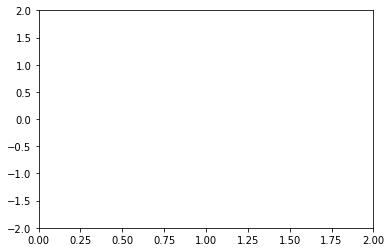

In [18]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
# NOTE: THIS WILL DISPLAY JUST AN EMPTY BOX.

In [20]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [22]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [23]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [24]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
frames=100, interval=20, blit=True)

In [25]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [26]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [28]:
circle {
  stroke: #000;
  stroke-opacity: .5;
}

    

var w = 600,
    h = 400;

var nodes = d3.range(50).map(function() { return {radius: Math.random() * 10 + 3}; }),
    color = d3.scale.category10();

var force = d3.layout.force()
    .gravity(0.1)
    .charge(function(d, i) { return i ? 0 : -2000; })
    .nodes(nodes)
    .size([w, h]);

var root = nodes[0];
root.radius = 0;
root.fixed = true;

force.start();

var svg = d3.select("#body").append("svg:svg")
    .attr("width", w)
    .attr("height", h);

svg.selectAll("circle")
    .data(nodes.slice(1))
  .enter().append("svg:circle")
    .attr("r", function(d) { return d.radius - 2; })
    .style("fill", function(d, i) { return color(i % 17); });

force.on("tick", function(e) {
  var q = d3.geom.quadtree(nodes),
      i = 0,
      n = nodes.length;

  while (++i < n) {
    q.visit(collide(nodes[i]));
  }

  svg.selectAll("circle")
      .attr("cx", function(d) { return d.x; })
      .attr("cy", function(d) { return d.y; });
});

svg.on("mousemove", function() {
  var p1 = d3.svg.mouse(this);
  root.px = p1[0];
  root.py = p1[1];
  force.resume();
});

function collide(node) {
  var r = node.radius + 16,
      nx1 = node.x - r,
      nx2 = node.x + r,
      ny1 = node.y - r,
      ny2 = node.y + r;
  return function(quad, x1, y1, x2, y2) {
    if (quad.point && (quad.point !== node)) {
      var x = node.x - quad.point.x,
          y = node.y - quad.point.y,
          l = Math.sqrt(x * x + y * y),
          r = node.radius + quad.point.radius;
      if (l < r) {
        l = (l - r) / l * .5;
        node.x -= x *= l;
        node.y -= y *= l;
        quad.point.x += x;
        quad.point.y += y;
      }
    }
    return x1 > nx2
        || x2 < nx1
        || y1 > ny2
        || y2 < ny1;
  };
}


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 32)

# Rotate an Image

In [4]:
from PIL import Image

def rotate(image_path, degrees_to_rotate, saved_location):
    """
    Rotate the given photo the amount of given degreesk, show it and save it

    @param image_path: The path to the image to edit
    @param degrees_to_rotate: The number of degrees to rotate the image
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    rotated_image = image_obj.rotate(degrees_to_rotate)
    rotated_image.save(saved_location)
    rotated_image.show()

if __name__ == '__main__':
    image = 'C:/Users/ltang/Desktop/Intranet/3DIMAGE.png'
    rotate(image, 90, 'C:/Users/ltang/Desktop/Intranet/rotated_3DIMAGE.png')